In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import os
from collections import Counter
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


In [14]:
def seed_assign(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [15]:
data_path = '/data2/spike_sorting/quiroga/'

filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
            "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
            "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
            "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]

# filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
#             "C_Easy1_noise025.mat", "C_Easy1_noise03.mat", "C_Easy1_noise035.mat", "C_Easy1_noise04.mat",
#             "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
#             "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
#             "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]


In [16]:
index = 0
current_dataset = data_path+filename[index]
print('현재 데이터 :', current_dataset)
mat1 = io.loadmat(current_dataset)
a = mat1['data'][0] # 1440000길이의 리스트 (24kHz로 60초동안 샘플링한 데이터)
print(f'데이터 길이 : {a.shape}')

a = mat1['spike_times']
print('스파이크 튀었던 시간 사이즈 : ',a[0][0][0].shape)


a = mat1['spike_class']
print('스파이크 클래스 사이즈 : ',a[0][0][0].shape)
print('스파이크 클래스 overlapping flag 사이즈 : ',a[0][1][0].shape)
print('스파이크 클래스 overlapping 간격 사이즈 : ',a[0][2][0].shape)


cls_label = a[0][0][0]
cls_overlapping_flag = a[0][1][0]
cls_overlapping_interval = a[0][2][0]

print('cls_label : ', cls_label)
print('cls_overlapping_flag : ', cls_overlapping_flag)
print('cls_overlapping_interval : ', cls_overlapping_interval)

cls_label_count = Counter(cls_label)
cls_overlapping_flag_count = Counter(cls_overlapping_flag)
cls_overlapping_interval_count = Counter(cls_overlapping_interval)

print('cls_label_count : ', cls_label_count)
print('cls_overlapping_flag_count : ', cls_overlapping_flag_count)
print('cls_overlapping_interval_count : ', cls_overlapping_interval_count)



현재 데이터 : /data2/spike_sorting/quiroga/C_Easy1_noise005.mat
데이터 길이 : (1440000,)
스파이크 튀었던 시간 사이즈 :  (3514,)
스파이크 클래스 사이즈 :  (3514,)
스파이크 클래스 overlapping flag 사이즈 :  (3514,)
스파이크 클래스 overlapping 간격 사이즈 :  (3514,)
cls_label :  [2 1 3 ... 2 1 2]
cls_overlapping_flag :  [0 0 0 ... 1 0 0]
cls_overlapping_interval :  [ 0  0  0 ... 14  0  0]
cls_label_count :  Counter({3: 1192, 1: 1165, 2: 1157})
cls_overlapping_flag_count :  Counter({0: 2729, 1: 785})
cls_overlapping_interval_count :  Counter({0: 2739, 1: 20, 37: 19, 28: 19, 30: 18, 16: 18, 53: 16, 2: 16, 36: 16, 44: 15, 6: 14, 35: 14, 4: 14, 5: 14, 19: 14, 55: 14, 74: 13, 34: 13, 65: 13, 49: 12, 41: 12, 24: 12, 62: 12, 17: 12, 66: 12, 40: 12, 15: 12, 21: 12, 20: 12, 77: 12, 38: 12, 8: 12, 42: 11, 52: 11, 73: 11, 9: 11, 25: 10, 32: 10, 58: 10, 11: 10, 68: 10, 7: 10, 10: 10, 26: 10, 56: 10, 12: 9, 64: 9, 18: 9, 59: 9, 31: 8, 75: 8, 69: 8, 14: 8, 61: 8, 39: 8, 47: 7, 48: 7, 71: 7, 63: 7, 45: 7, 54: 6, 50: 6, 33: 6, 43: 6, 67: 6, 70: 6, 3: 6, 46:

training_spike_group_reshape (38400, 50) training_spike_group_label_reshape (38400, 3)
test_spike_data (16930, 50) test_spike_label (16930, 3)


/tmp/ipykernel_13938/637571470.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


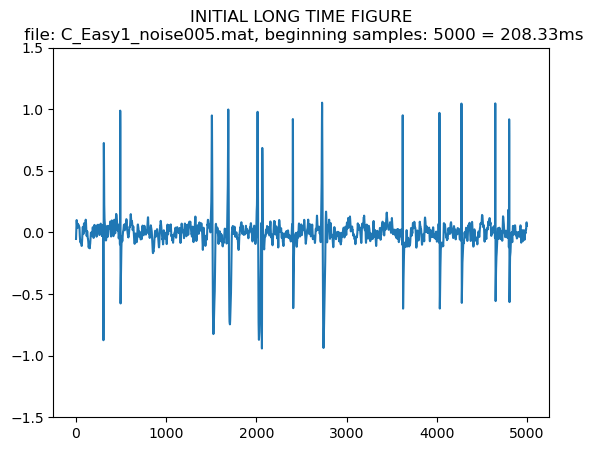

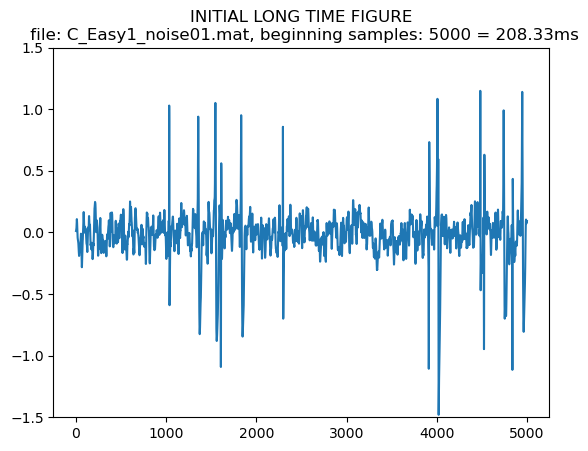

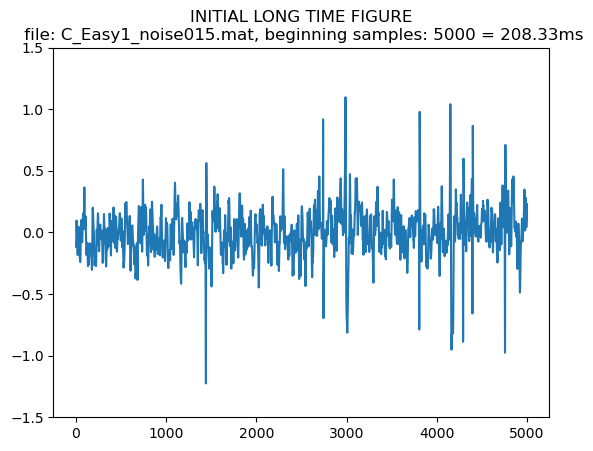

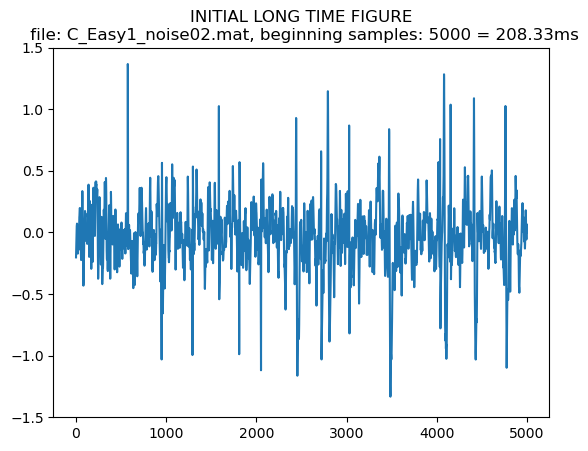

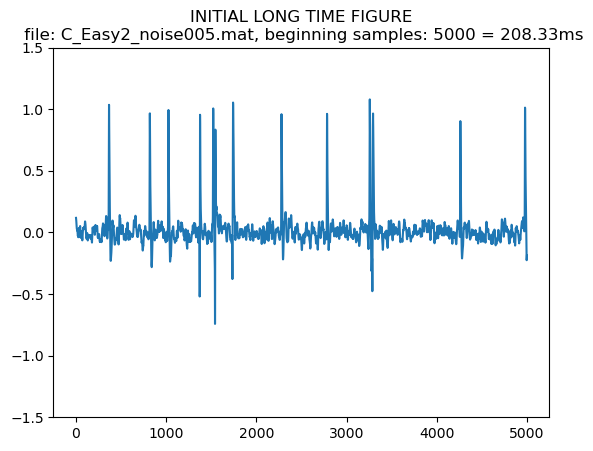

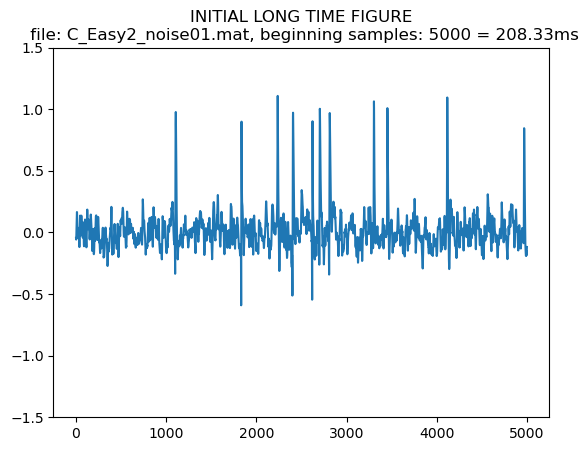

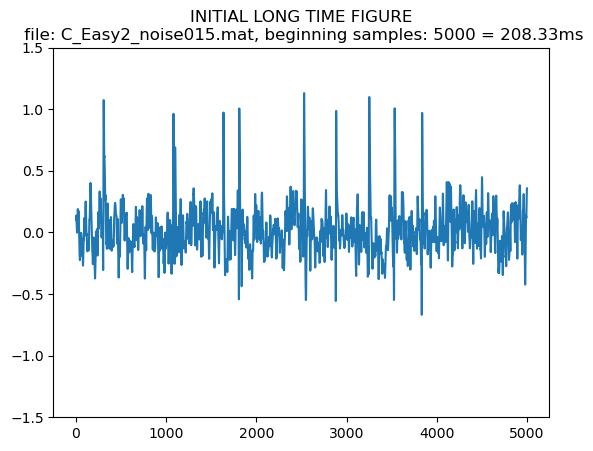

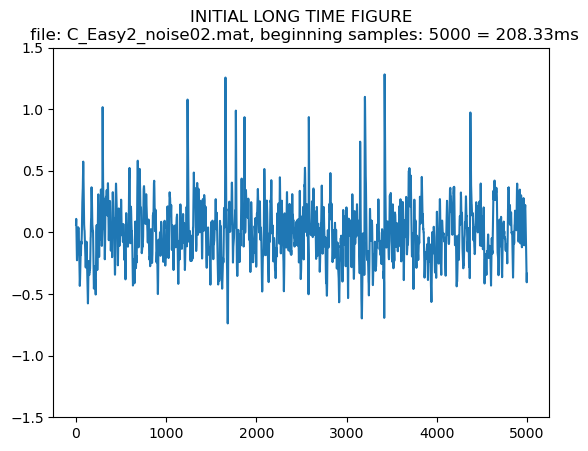

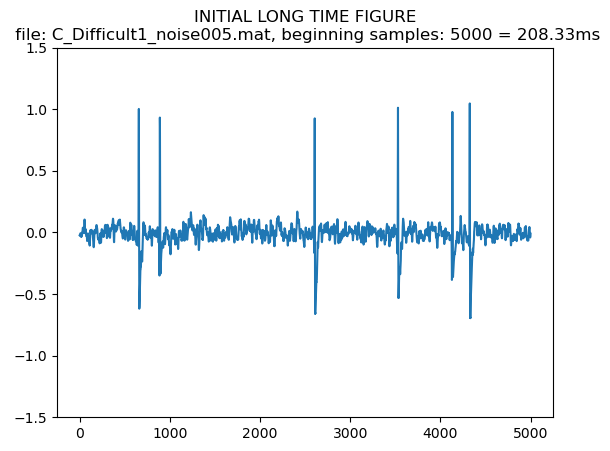

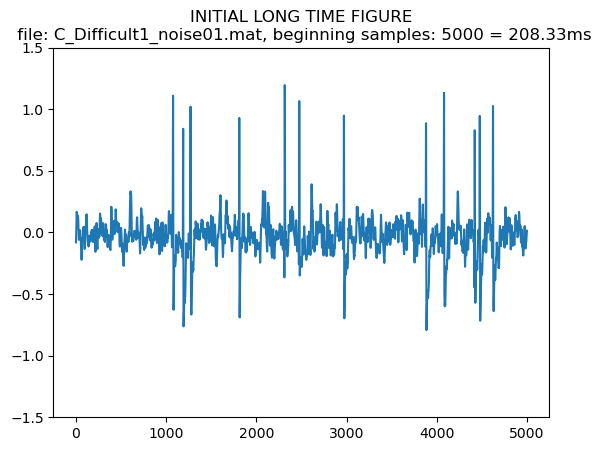

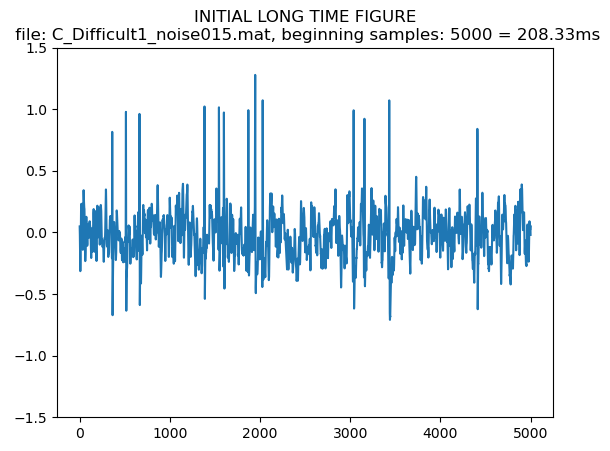

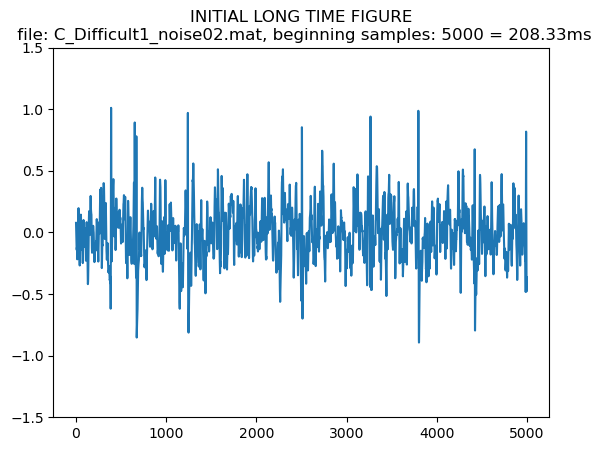

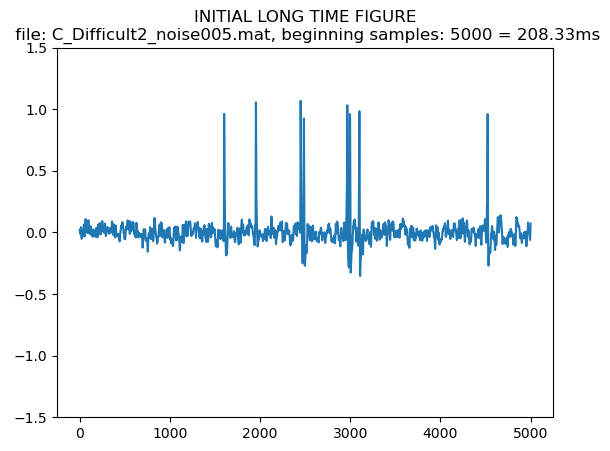

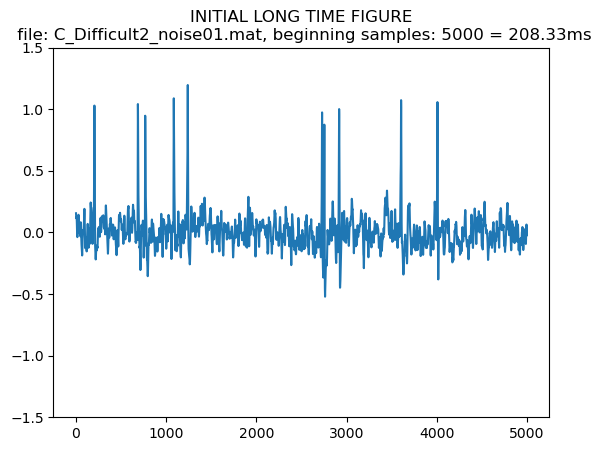

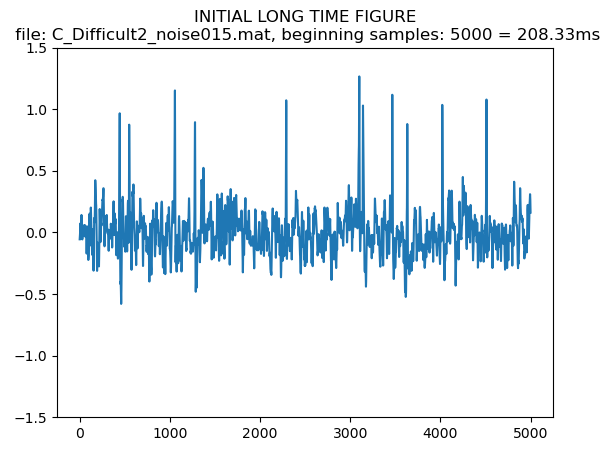

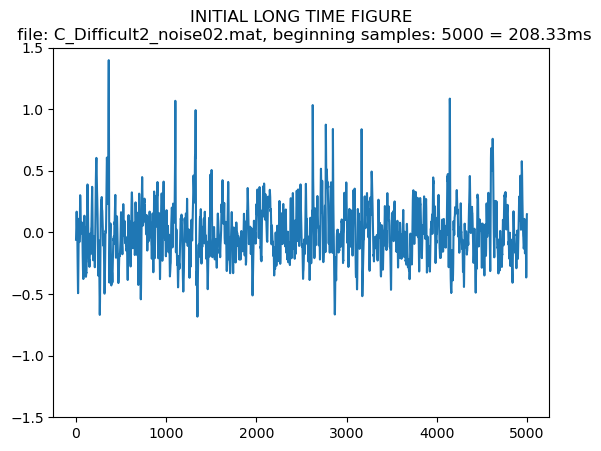

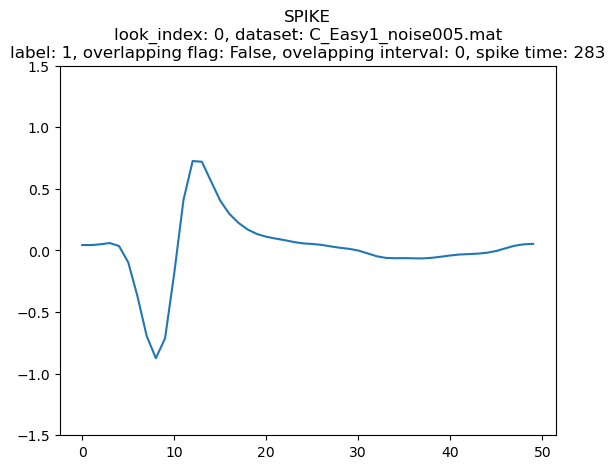

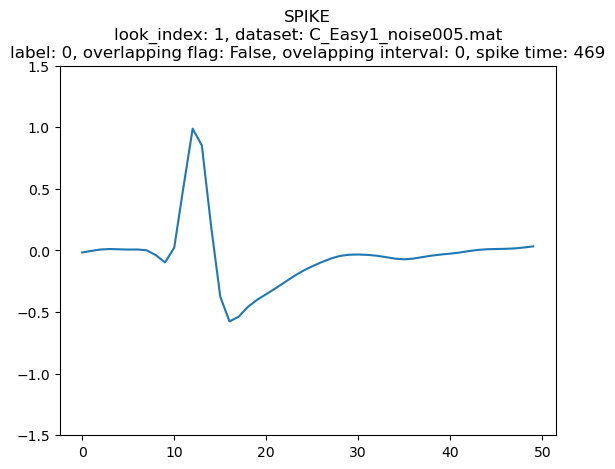

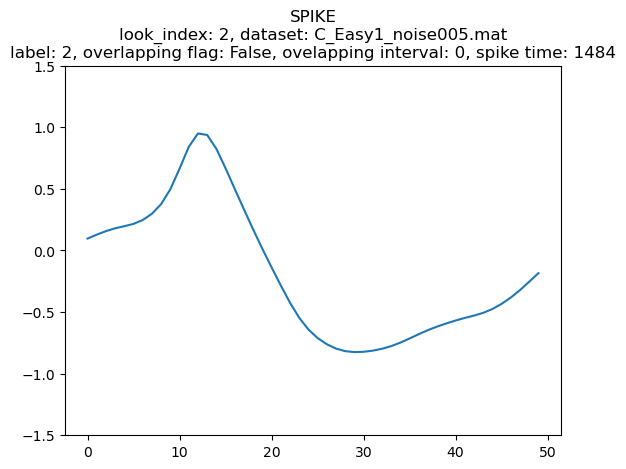

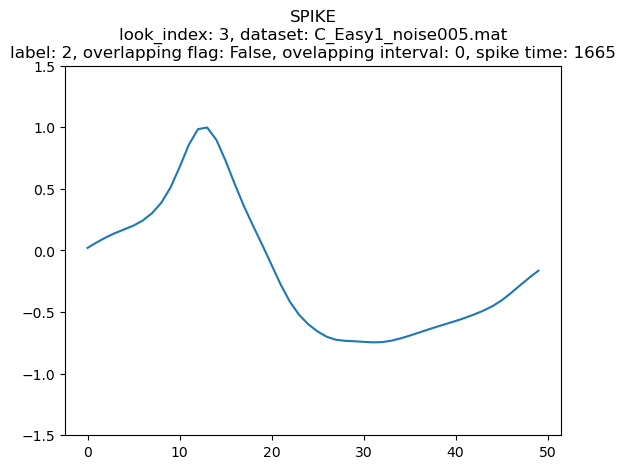

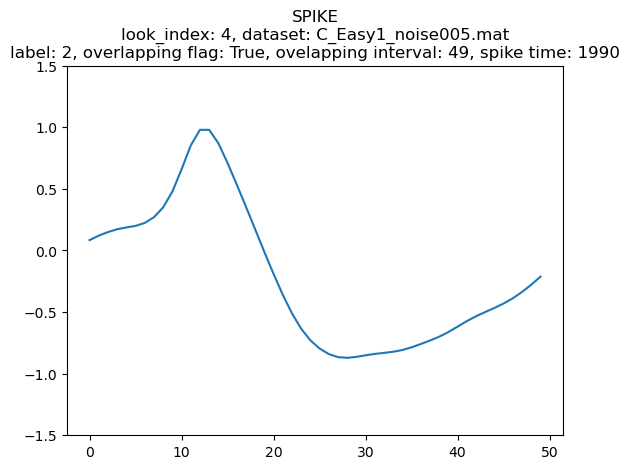

In [17]:
from cgi import test


dataset_num = 16
training_num = 2400
spike_length = 50 #300
max_index_left = 10 #0
max_index_right = spike_length - max_index_left
initial_long_time_figure = 5_000 # 최대 1,440,000 개 = 24000Hz*60s
my_seed = 42

seed_assign(my_seed)

training_spike_group = np.zeros((dataset_num, training_num, spike_length))
training_spike_group_label = np.zeros((dataset_num, training_num, 3))
training_spike_group_time = np.zeros((dataset_num, training_num))

test_spike_data = np.empty((0, spike_length))
test_spike_label = np.empty((0, 3))

for ds in range(dataset_num):
    mat1 = io.loadmat(data_path+filename[ds])
    raw = mat1['data'][0]
    ans_times = mat1['spike_times'][0][0][0]

    plt.figure()
    x = np.arange(0, initial_long_time_figure, 1)
    plt.plot(x, raw[:initial_long_time_figure]) 
    plt.ylim(-1.5, 1.5)  # y축 범위를 -1.5에서 1.5로 고정
    plt.title(f'INITIAL LONG TIME FIGURE\n file: {filename[ds]}, beginning samples: {initial_long_time_figure} = {initial_long_time_figure/24:.2f}ms')
    
    slope = np.zeros(len(raw)-1) # 왜 여기 -2? -1만 해도 되지않나
    for i in range(len(raw)-1):
        slope[i] = raw[i+1] - raw[i]

    spike_group = np.zeros((len(ans_times), spike_length))
    spike_group_label = np.stack([mat1['spike_class'][0][0][0], mat1['spike_class'][0][1][0], mat1['spike_class'][0][2][0]], axis=-1)
    
    for i in range(len(ans_times)):
        max_slope_index = ans_times[i] + np.argmax(slope[ans_times[i] : ans_times[i] + 25])
        # max_slope_index = ans_times[i] 
        spike_group[i, :] = raw[max_slope_index - max_index_left : max_slope_index + max_index_right]

    '''#max_slope_idx_check
    max_slope_index = np.zeros(len(ans_times))
    
    for i in range(len(ans_times)):
        slope_value = np.zeros(49)
        for j in range(49):
            slope_value[j] = abs(spike_group[i, j+1] - spike_group[i, j])
        max_slope_index[i] = np.argmax(slope_value)
    print(max_slope_index)

    x = np.arange(0, 50, 1)
    plt.figure()
    plt.plot(x, spike_group[0, :])
    plt.savefig('./../result_net/etc/spike.svg')

    '''
    
    training_spike_group[ds, :, :] = spike_group[:training_num, :]
    spike_group_label[:, 0] = spike_group_label[:, 0].astype(np.int16) + (ds // 4) * 3 - 1
    training_spike_group_label[ds, :] = spike_group_label[:training_num]
    training_spike_group_time[ds, :] = ans_times[:training_num]

    test_spike_data = np.vstack([test_spike_data, spike_group[training_num:]])
    test_spike_label = np.vstack([test_spike_label, spike_group_label[training_num:]])
    

training_spike_group_reshape = training_spike_group.reshape(-1, spike_length)
training_spike_group_label_reshape = training_spike_group_label.reshape(-1, 3) # 그 클래스가 3개(label, overlapping flag, ovelapping interval)가 있잖아.
training_spike_group_time_reshape = training_spike_group_time.reshape(-1)

test_spike_data_reshape = test_spike_data # no change
test_spike_label_reshape = test_spike_label # no change

# check dataset
print('training_spike_group_reshape', np.shape(training_spike_group_reshape), 'training_spike_group_label_reshape', np.shape(training_spike_group_label_reshape))
print('test_spike_data', np.shape(test_spike_data), 'test_spike_label', np.shape(test_spike_label))

print_num = 5
random_look_index_list = random.sample(range(np.shape(training_spike_group_reshape)[0]), print_num)
random_look_index_list = range(print_num)
for look_index in random_look_index_list:
    plt.figure()
    x = np.arange(0, spike_length, 1)
    plt.plot(x, training_spike_group_reshape[look_index, :]) 
    plt.ylim(-1.5, 1.5)  # y축 범위를 -1.5에서 1.5로 고정
    plt.title(f'SPIKE\nlook_index: {look_index}, dataset: {filename[look_index//training_num]}\nlabel: {int(training_spike_group_label_reshape[look_index][0])}, overlapping flag: {True if int(training_spike_group_label_reshape[look_index][1]) == 1 else False}, ovelapping interval: {int(training_spike_group_label_reshape[look_index][2])}, spike time: {int(training_spike_group_time_reshape[look_index])}')
    # plt.savefig('spike/spike.svg')


In [18]:
train_data = training_spike_group_reshape
train_label = training_spike_group_label_reshape[:,0]
train_data = torch.tensor(train_data, dtype=torch.float32)  # 데이터를 Tensor로 변환
train_label = torch.tensor(train_label, dtype=torch.long)  # 레이블을 Long 타입으로 변환 (분류 문제일 경우)

test_data = test_spike_data_reshape
test_label = test_spike_label_reshape[:,0]
test_data = torch.tensor(test_data, dtype=torch.float32)  # 데이터를 Tensor로 변환
test_label = torch.tensor(test_label, dtype=torch.long)  # 레이블을 Long 타입으로 변환 (분류 문제일 경우)

print('train_data', train_data.shape, 'train_label', train_label.shape)
print('train_data', test_data.shape, 'test_label', test_label.shape)

torch.save(train_data, data_path+'train/data_temp.pt')
torch.save(train_label, data_path+'train/label_temp.pt')
torch.save(test_data, data_path+'test/data_temp.pt')
torch.save(test_label, data_path+'test/label_temp.pt')


train_data torch.Size([38400, 50]) train_label torch.Size([38400])
train_data torch.Size([16930, 50]) test_label torch.Size([16930])
